PGL monitor calibration


In [160]:
%load_ext autoreload
%autoreload 2

# library imports
from matplotlib import pyplot as plt
import numpy as np

# Load PGL libraries and start a PGL window
from pgl import pgl as pglLibrary
pgl = pglLibrary()

# close any existing windows
pgl.cleanUp()

# open a new window
pgl.open(0,800,600)
pgl.visualAngle(57, 60,40)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
================================ pglBase: init =================================
(pgl:checkOS) Python version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:35:20) [Clang 16.0.6 ]
(pgl:checkOS) Running on MacBook Pro (MacBookPro18,3) with macOS version: 26.2
(pgl:checkOS) Apple M1 Pro Cores: 8 (6 performance and 2 efficiency) Memory: 32 GB
(pgl:checkOS) GPU: Apple M1 Pro (Built-In) 14 cores, Metal 4 support
(pgl:checkOS)   Color LCD [Main Display]: 3024 x 1964 Retina (Built-in Liquid Retina XDR Display) GammaTable size: 1024
(pglBase) Main library instance created
(pglBase:removeOrphanedSockets) Removing orphaned socket: /Users/justin/Library/Containers/gru.mglMetal/Data/pglMetal.socket.20260211_124800.8iDRlIlDdq
(pglBase:removeOrphanedSockets) Removed 1 orphaned sockets
================================= pglBase:open =================================
(pglBase:open) Starting mglMetal appl

Now, let's measure the temporal frequency response of the display using a photodiode. For this, you will need to do the following:

- Connect photodiode to Hamamatsu Amp via the BNC connector
- Connect the output of Hamamastu Amp to the Labjack A0 input
- Connect the USB of the Labjack to the computer
- Position the photodiode so that it is on the monitor


The following code will init the LabJack. Take a look at the output and make sure that it does not report an error loading LabJack.

In [161]:
# import pglLabJack and create an instance
from pgl import pglLabJack
pglLabJack = pglLabJack()

(pglDevice) Cleaning up device of type LabJack
(pglLabJack) Opened T7 LabJack device via USB connection.
             serialNumber: 470040275 ipAddress: 0 port: 0 maxBytesPerMB: 64


We now will flicker the screen and display the output

In [ ]:
# set stimulus duration in seconds
stimulusDuration = 5

# open as full screen
#pgl.fullScreen(True)
#pgl.waitSecs(0.5)

# setup digital output for sync pulse (optional, but recommended for precise timing)
pglLabJack.setupDigitalOutput(channel=0)
pglLabJack.digitalOutput(0)

# read analog input for a little bit beyond stimulus duration
startTime = pgl.getSecs()
analogReadDuration = stimulusDuration + 0.1
pglLabJack.startAnalogRead(duration=analogReadDuration, channels=['AIN0','AIN1'])

# arrays of timestamps
cycleStartTime = []
cycleStartFlushTime = []
flushTime = []

# frequency of the flickering stimulus in Hz
temporalFrequency = 30

# whether to compute stimulus based on targetPresentationTimestamp
# or based on frame count
framewise = True

# start flickering stimulus
flicker = pgl.flicker(pgl, temporalFrequency=temporalFrequency, type='sine', phase=-90, framewise=framewise)

#display first frame with a synchronization pulse
timestamp = pglLabJack.digitalOutput(1)
flicker.display()

# keep timestamps
flushTime.append(pgl.flush())
cycleStartTime.append(timestamp)
cycleStartFlushTime.append(flushTime[-1])

while pgl.getSecs() - startTime < stimulusDuration:
    # display the stimulus, which returns True at the beginning of each cycle and False otherwise
    newCycle = flicker.display()
    # if this was a beginning of cycle, then keep track of the cycle start time and flush time
    if newCycle:
        # set the digital ouptut high if this frame is the beginning of a cycle
        timestamp = pglLabJack.digitalOutput(1, pulseLen=2)
        cycleStartTime.append(timestamp)
        cycleStartFlushTime.append(flushTime[-1])
    # flush the screen, recording the time of each flush for later analysis
    flushTime.append(pgl.flush())

# get analog data
time, data = pglLabJack.stopAnalogRead(waitToFinish=True)

# close full screen
pgl.fullScreen(False)

# plot data
#pglLabJack.plotAnalogRead(time, data, cycleLen=1/temporalFrequency)
pglLabJack.plotAnalogRead(time, data, digitalSyncChannel=1, digitalSyncThreshold=2, ignoreInitial=0.5, displayStartEnd=2/temporalFrequency)

# compute average delay between digital sync pulse and screen refresh
syncDelays = np.array(cycleStartFlushTime) - np.array(cycleStartTime)
#print(f"cycleStartFlushTime): {cycleStartFlushTime}")
#print(f"cycleStartTime: {cycleStartTime}")
print(f"Median delay between digital sync pulse and screen refresh: {np.median(syncDelays)*1000:.2f} ms (n={len(syncDelays)})")

# compute mean, median, std of difference of flush times
flushDiffs = np.diff(flushTime)
medianFrameLength = np.median(flushDiffs)
print(f"FrameLengths: median={medianFrameLength*1000:.2f} ms")
# compute number of dropped frames (defined as flushDiffs > 1.1*medianFrameLength)
droppedFrames = np.sum(flushDiffs > 1.1 * medianFrameLength)
print(f"Dropped frames: {droppedFrames}/{len(flushDiffs)}, {np.where(flushDiffs > 1.1 * medianFrameLength)[0]}")


(pglLabJack:setupDigitalOutput) Error setting up FIO0: LJM library error code 1239 LJME_RECONNECT_FAILED
(pglLabJack:setDigitalOutput) Error reading FIO0: LJM library error code 1239 LJME_RECONNECT_FAILED
(pglLabJack:startAnalogRead) totalScans (5100) is not an integer multiple of scansPerRead (1000). Will collect 6000 samples instead of 5100 and throw out extra samples.
(pgl:_resolution:getResolution) Display 0/1: 1512x982 120Hz 32bits
(pgl:pglStimulusFlicker:init) Warning: temporalFrequency of 30 Hz corresponds to a non-integer number of frames per cycle (4.0). This may lead to temporal aliasing. Consider choosing a temporal frequency that is a divisor of the frame rate (120 Hz) to avoid this issue. Using 4 frames per cycle instead.
(pglLabJack:analogReadThread) Error starting stream: LJM library error code 1239 LJME_RECONNECT_FAILED
(pglLabJack:setDigitalOutput) Error reading FIO0: LJM library error code 1239 LJME_RECONNECT_FAILED
(pglLabJack:setDigitalOutput) Error reading FIO0: LJ

TypeError: unsupported operand type(s) for -: 'float' and 'NoneType'

Time array shape: (20000,)
Data array shape: (20000, 2)
Time range: 0.0000 to 1.9999 seconds
Sampling rate: 10000 Hz
Number of samples: 20000
Channel 0 range: -0.162 to 5.158 V
Channel 1 range: 0.000 to 3.300 V
Number of cycles: 10
(pglLabJack:getCycles) Ignoring first 0.5s (5000 samples)


<string>:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


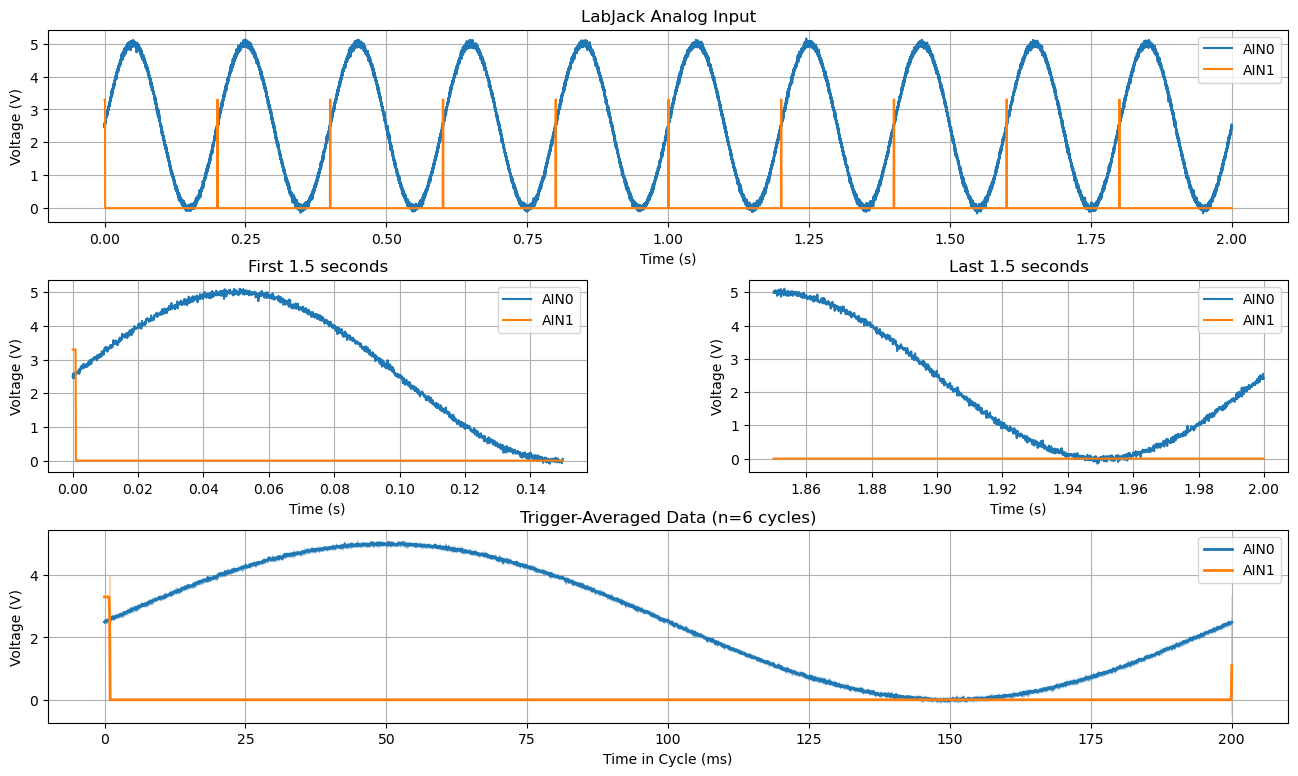

In [165]:
import numpy as np
import matplotlib.pyplot as plt

# Sampling parameters
scanRate = 10000  # 10 kHz sampling rate
duration = 2.0  # 2 seconds of data
time = np.arange(0, duration, 1/scanRate)

# Signal parameters
frequency = 5  # 5 Hz sinusoid
amplitude = 2.5  # 2.5V amplitude
offset = 2.5  # 2.5V offset (to keep it between 0-5V)

# Create sinusoidal signal for channel 0
channel0 = amplitude * np.sin(2 * np.pi * frequency * time) + offset

# Add some realistic noise
noiseLevel = 0.05  # 50 mV RMS noise
channel0 += np.random.normal(0, noiseLevel, len(time))

# Create digital sync pulse for channel 1
channel1 = np.zeros_like(time)
pulseVoltage = 3.3  # 3.3V digital pulse
pulseDuration = 0.001  # 1 ms pulse width
cyclePeriod = 1.0 / frequency  # Period of one cycle (0.2 seconds for 5 Hz)

# Add pulses at the beginning of each cycle
numCycles = int(duration * frequency)
for cycle in range(numCycles):
    pulseStartTime = cycle * cyclePeriod
    pulseEndTime = pulseStartTime + pulseDuration
    
    # Find indices for this pulse
    pulseIndices = (time >= pulseStartTime) & (time < pulseEndTime)
    channel1[pulseIndices] = pulseVoltage

# Combine into data array (samples x channels)
data = np.column_stack((channel0, channel1))

# Print some info about the generated data
print(f"Time array shape: {time.shape}")
print(f"Data array shape: {data.shape}")
print(f"Time range: {time[0]:.4f} to {time[-1]:.4f} seconds")
print(f"Sampling rate: {scanRate} Hz")
print(f"Number of samples: {len(time)}")
print(f"Channel 0 range: {np.min(channel0):.3f} to {np.max(channel0):.3f} V")
print(f"Channel 1 range: {np.min(channel1):.3f} to {np.max(channel1):.3f} V")
print(f"Number of cycles: {numCycles}")

pglLabJack.plotAnalogRead(time, data, digitalSyncChannel=1, digitalSyncThreshold=2, ignoreInitial=0.5, displayStartEnd=1.5)


Read the gamma table and display it

In [ ]:
# Read the gamma table
gammaTable = pgl.getGammaTable(0)

# display it
plt.plot(gammaTable[0], label='Red')
plt.plot(gammaTable[1], label='Green')
plt.plot(gammaTable[2], label='Blue')
plt.title('Gamma Table')
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.legend()
plt.show()

Set gamma table

In [ ]:
# Get the size of the gamma table
displayNumber = 0
tableSize = pgl.getGammaTableSize(displayNumber)
print(f"Gamma table size: {tableSize}")

# create a gamma table
gamma = 1
lin = np.linspace(0, 1, tableSize, dtype=np.float32)
red = lin ** gamma
green = lin ** gamma
blue = lin ** gamma

# set it
pgl.setGammaTable(displayNumber, red, green, blue)

Setup minolta device

- Connect ...

In [ ]:
# initialize minolta calibration device
from pgl import pglCalibrationDeviceMinolta, pglCalibration
pglMinolta = pglCalibrationDeviceMinolta()

Make a measurement

In [ ]:
pglMinolta.measure()

Run a calibration

In [ ]:
# initialize the calibration with the minolta device
pglCal = pglCalibration(pgl, pglMinolta)

# Run the calibration with 8 luminance steps and 2 repeats of each measurement 
pglCal.calibrate(nSteps=8, nRepeats=2)

In [83]:
targetPresentationTimestamp = np.array([])
preFlushTimestamp = np.array([])
postFlushTimestamp = np.array([])
flushTimestamp = np.array([])

pgl.flush();
pgl.printCommandResults()
pgl.flush();pgl.flush();pgl.flush();pgl.flush()
for iFrame in range(50):
    targetPresentationTimestamp = np.append(targetPresentationTimestamp, pgl.getTargetPresentationTimestamp())
    preFlushTimestamp = np.append(preFlushTimestamp, pgl.getSecs())
    flushTimestamp = np.append(flushTimestamp, pgl.flush())
    postFlushTimestamp = np.append(postFlushTimestamp, pgl.getSecs())

# Compute differences between consecutive timestamps
deltas = np.diff(targetPresentationTimestamp)  # array of differences in seconds

# Compute median
medianDelta = np.median(deltas)

print("targetPresentationTimestamps:\n", targetPresentationTimestamp)
print("Flush timestamps:\n", flushTimestamp)


#print("Frame-to-frame deltas:", deltas)
print("Median delta (seconds):", medianDelta)
#print("Frame-to-frame deltas (getSecs):", deltasSecs)
#print("Median delta (getSecs seconds):", medianDeltaSecs)

target_ms = 1000 * (targetPresentationTimestamp - preFlushTimestamp[0])
pre_ms    = 1000 * (preFlushTimestamp - preFlushTimestamp[0])
flush_ms  = 1000 * (flushTimestamp - preFlushTimestamp[0])
post_ms   = 1000 * (postFlushTimestamp - preFlushTimestamp[0])

# Print with fixed width, 1 decimal
fmt = {'float_kind': lambda x: f"{x:6.1f}"}

print("Target presentation timestamps:\n", np.array2string(target_ms, formatter=fmt))
print("Pre-flush timestamps:\n", np.array2string(pre_ms, formatter=fmt))
print("Flush timestamps:\n", np.array2string(flush_ms, formatter=fmt))
print("Post-flush timestamps:\n", np.array2string(post_ms, formatter=fmt))

print("Actual-target:\n", np.array2string(flush_ms-target_ms, formatter=fmt))



(pglBase:printCommandResults) ack: 108302664.000 ms (relative to 108411.0703125)
(pglBase:printCommandResults) commandCode: 1001
(pglBase:printCommandResults) success: 1
(pglBase:printCommandResults) processedTime: 108302664.000 ms (relative to 108411.0703125)
(pglBase:printCommandResults) vertexStart: 108302656.000 ms
(pglBase:printCommandResults) vertexEnd: 108302656.000 ms
(pglBase:printCommandResults) drawableAcquired: -108410.961 ms
targetPresentationTimestamps:
 [108411.14881821 108411.16548488 108411.18215154 108411.21131775
 108411.22798442 108411.24465108 108411.26131775 108411.27798442
 108411.29465108 108411.31131775 108411.32798442 108411.34465025
 108411.36131692 108411.37798358 108411.39465025 108411.41131692
 108411.42798358 108411.44465025 108411.46131692 108411.47798358
 108411.49465025 108411.51131692 108411.52798358 108411.54465025
 108411.56131692 108411.57798358 108411.59465025 108411.61131692
 108411.62798358 108411.64465025 108411.66131692 108411.67798358
 108411